In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns

/dsw/snapshots/snapshot_dsw_default_jupyter/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
# Label: The hourly average gb per plan per scan at city-level
# Feature Set:
#     X1: driver_cancel_prob
#     X2: rider_cancel_prob
#     X3: spinner_cancel_prob
#     X4: eta
#     X5: surge_mul
#     X6: gb

#     X7: eta_square = (1 - X4/1500)**2
#     X8: eta_cube = (1 - X4/1500)**3
#     X9: network_contention = 1 / (1 + X5^5)
#     X10: cr_ratio = (1 - X1) * (1 - X2) * (1 - X3)

#     X11: eta_square_cr_ratio = X7 * X10
#     X12: eta_cube_cr_ratio = X8 * X10
#     X13: network_eta_cr_ratio = X7 * X9 * X10
#     X14: network_eta_gb_cr_ratio = X7 * (1 - X9) * X10 * X6

In [3]:
# Read in data: features & labels
df_features_dict = {}
df_labels_dict = {}

for i in range(1, 11):
    df_features_dict[i] = pd.read_csv(f'features_{i}.csv')
    df_labels_dict[i] = pd.read_csv(f'labels_{i}.csv')

In [4]:
df_features_frames = [df_features_dict[1], df_features_dict[2], df_features_dict[3],
                      df_features_dict[4], df_features_dict[5], df_features_dict[6],
                      df_features_dict[7], df_features_dict[8], df_features_dict[9],
                      df_features_dict[10]]

df_labels_frames = [df_labels_dict[1], df_labels_dict[2], df_labels_dict[3],
                    df_labels_dict[4], df_labels_dict[5], df_labels_dict[6],
                    df_labels_dict[7], df_labels_dict[8], df_labels_dict[9],
                    df_labels_dict[10]]

In [5]:
df_features = pd.concat(df_features_frames, ignore_index=True)
df_labels = pd.concat(df_labels_frames, ignore_index=True)

In [6]:
df_features.drop('num_plans', axis=1, inplace=True)
df_labels.drop('num_plans', axis=1, inplace=True)

In [7]:
df = pd.merge(df_features, df_labels,
              how='left',
              left_on=['datestr', 'city_id', 'hour_of_day'],
              right_on=['datestr', 'city_id', 'hour_of_day']
             )

In [8]:
y = df['hour_gb']
X = df.drop(['hour_gb', 'datestr', 'city_id', 
             'hour_of_day', 
             'market_eta',
             'market_gb',
             'market_eta_square',
             'market_eta_square_cr_ratio',
             'market_spinner_cancel_prob',
             'market_rider_cancel_prob',
             'market_cr_ratio',
             'market_network_contention',
             'market_eta_cube_cr_ratio'], 
            axis=1)

In [9]:
X['intercept'] = pd.Series([1 for _ in range(len(X.index))])

In [10]:
X

,market_drive_cancel_prob,market_surge_mul,market_eta_cube,market_network_eta_cr_ratio,market_network_eta_gb_cr_ratio,intercept
0,0.739296,1.363636,0.657055,0.035209,2.828381,1
1,0.652287,1.381818,0.295023,0.011593,3.353401,1
2,0.682259,1.283333,0.396850,0.031121,3.470962,1
3,0.723331,1.000000,0.178405,0.045039,0.975321,1
4,0.618826,1.166667,0.421898,0.079729,3.155870,1
...,...,...,...,...,...,...
10609,0.597781,1.004027,0.702350,0.151809,0.397718,1
10610,0.615688,1.002484,0.682206,0.140471,0.349518,1
10611,0.687489,1.013497,0.648528,0.106140,0.290362,1
10612,0.714922,1.014857,0.608461,0.092902,0.240974,1


In [11]:
# Scale y
y = y / 10

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)

In [13]:
model = sm.OLS(y_train, X_train)

In [14]:
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:                hour_gb   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     4369.
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        18:32:32   Log-Likelihood:                -1962.8
No. Observations:                8491   AIC:                             3938.
Df Residuals:                    8485   BIC:                             3980.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
market_drive

In [15]:
# Train RMSE
y_train_pred = trained_model.predict(X_train)
train_rmse = np.sqrt(np.mean((y_train - y_train_pred)**2))
train_rmse

0.3049002244374754

In [16]:
# Test RMSE
y_test_pred = trained_model.predict(X_test)
test_rmse = np.sqrt(np.mean((y_test - y_test_pred)**2))
test_rmse

0.28686697012622336

In [17]:
y_train.describe()

count    8491.000000
mean        0.678712
std         0.576472
min         0.213940
25%         0.313027
50%         0.423438
75%         0.622321
max         3.797802
Name: hour_gb, dtype: float64

In [18]:
y_test.describe()

count    2123.000000
mean        0.654854
std         0.563477
min         0.220372
25%         0.309151
50%         0.407085
75%         0.592107
max         3.181440
Name: hour_gb, dtype: float64

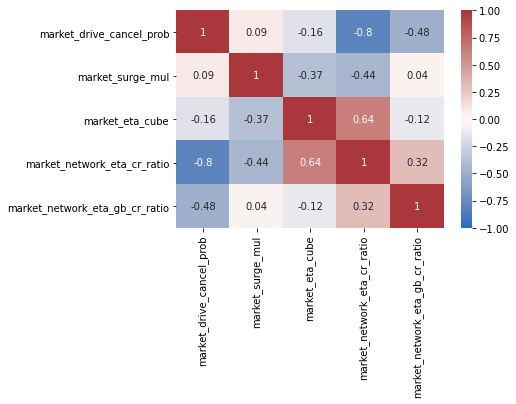

In [19]:
# Visualizing a Pandas Correlation Matrix
train_corr_matrix = X_train.loc[:, X_train.columns != 'intercept'].corr().round(2)
sns.heatmap(train_corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()

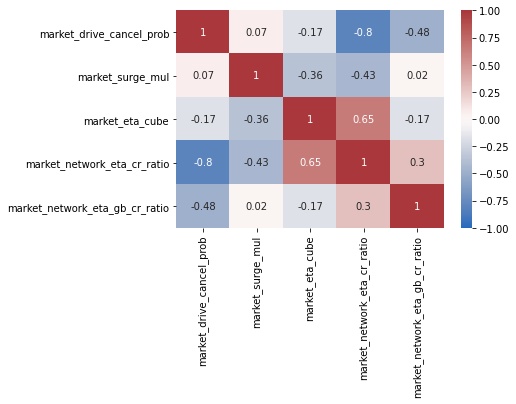

In [20]:
test_corr_matrix = X_test.loc[:, X_train.columns != 'intercept'].corr().round(2)
sns.heatmap(test_corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()